In [48]:
import torch

import os
os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [105]:
torch.manual_seed(0)

trellis_block = torch.randint(-2**31, 2**31, (4, 2), dtype=torch.int32, device="cuda")

print(trellis_block)
print()

mask = 0b11111111
shifter = torch.arange(0, 32, 8).cuda()
shifter_1_odd = torch.where(torch.arange(8, 40, 8) == 32, 0, torch.arange(8, 40, 8)).cuda()

row1_even = (trellis_block[0][:, None] >> shifter[None, :]) & mask 
row1_odd = (trellis_block[0][:, None] >> shifter_1_odd[None, :]) & mask

print(row1_even)
print(row1_odd)

row2 = (trellis_block[1][:, None] >> shifter[None, :]) & mask
row3 = (trellis_block[2][:, None] >> shifter[None, :]) & mask
row4 = (trellis_block[3][:, None] >> shifter[None, :]) & mask

col_even_1 = (row1_even << 8) | row2
col_even_2 = (row3 << 8) | row4

print(col_even_1)
print(col_even_2)

col_odd_1 = (row2 << 8) | row3
col_odd_2 = (row4 << 8) | row1_odd

print(col_odd_1)
print(col_odd_2)


col = torch.stack([col_even_1, col_odd_1, col_even_2, col_odd_2], axis=0)#.reshape(-1)
print()
print(col)

tensor([[ 1634321805,  1888317098],
        [  914515801, -1856465224],
        [  253374599,   707591386],
        [  334183809,   375137601]], device='cuda:0', dtype=torch.int32)

tensor([[141, 197, 105,  97],
        [170, 110, 141, 112]], device='cuda:0')
tensor([[197, 105,  97, 141],
        [110, 141, 112, 170]], device='cuda:0')
tensor([[36185, 50535, 27010, 24886],
        [43704, 28310, 36184, 28817]], device='cuda:0')
tensor([[34689, 12349,  6891,  3859],
        [55873, 64549, 11356, 10774]], device='cuda:0')
tensor([[22919, 26416, 33306, 13839],
        [47322, 38652, 22572, 37162]], device='cuda:0')
tensor([[33221, 15721, 60257,  5005],
        [16750,  9613, 23664,  5802]], device='cuda:0')

tensor([[[36185, 50535, 27010, 24886],
         [43704, 28310, 36184, 28817]],

        [[22919, 26416, 33306, 13839],
         [47322, 38652, 22572, 37162]],

        [[34689, 12349,  6891,  3859],
         [55873, 64549, 11356, 10774]],

        [[33221, 15721, 60257,  5005],
      

In [108]:
@triton.jit
def test_trellis_kernel(
        b_ptr, out_ptr
):
    # pid = tl.program_id(axis=0)

    # load_offs = tl.arange(0, 1)
    # load_offs = load_offs[:, None] * load_offs[None, :]
    
    # b1 = tl.load(b_ptr + load_offs)
    # b2 = tl.load(b_ptr + load_offs + 1)
    # b3 = tl.load(b_ptr + load_offs + 2)
    # b4 = tl.load(b_ptr + load_offs + 3)

    b1 = tl.load(b_ptr)
    b2 = tl.load(b_ptr + 1)
    b3 = tl.load(b_ptr + 2)
    b4 = tl.load(b_ptr + 3)


    mask = 0b11111111
    shifter = tl.arange(0, 4) * 8
    shifter_1_odd = tl.where((shifter + 8) == 32, 0, shifter + 8)

    row1_even = (b1 >> shifter) & mask 
    row1_odd = (b1 >> shifter_1_odd) & mask

    print(row1_even)
    print(row1_odd)

    row2 = (b2 >> shifter) & mask
    row3 = (b3 >> shifter) & mask
    row4 = (b4 >> shifter) & mask

    col_even_1 = (row1_even << 8) | row2
    col_even_2 = (row3 << 8) | row4
    col_odd_1 = (row2 << 8) | row3
    col_odd_2 = (row4 << 8) | row1_odd

    b_1 = tl.join(col_even_1, col_even_2)
    b_2 = tl.join(col_odd_1, col_odd_2)
    b = tl.join(b_1, b_2)
    out_ptrs = out_ptr + tl.arange(0, 16)
    tl.store(out_ptrs, b.reshape(16))


def test_triton_trellis(b_compressed):
    # assert tuple(b_compressed.shape) == (4, 1)

    out = torch.empty((16,), device=b_compressed.device, dtype=torch.int32)
    grid = (1,)

    test_trellis_kernel[grid](
        b_compressed, out
    )
    return out


test_triton_trellis(trellis_block)

[141 197 105  97]
[197 105  97 141]


tensor([36266, 43609, 22968, 47301, 50542, 28263, 26518, 38505, 27021, 36226,
        33368, 22625, 24944, 28726, 13969, 37261], device='cuda:0',
       dtype=torch.int32)

In [ ]:
def _get_cuda_autotune_config():
    configs = []
    for num_warps, num_stages in [
        (4, 2),
        (4, 3),
        (4, 4),
    ]:
        for GROUP_SIZE_M in [1, 8, 128]:
            for BLOCK_SIZE_M in [16]:
                for BLOCK_SIZE_N in [16, 32, 64]:#[64, 128]:
                    for BLOCK_SIZE_K in [128, 256]:#[16, 32]:
                        configs.append(
                            triton.Config(
                                {
                                    "GROUP_SIZE_M" : GROUP_SIZE_M,
                                    "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                    "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                    "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                                }, 
                                num_stages=num_stages, 
                                num_warps=num_warps
                            ),
                        )                        
    # return configs

    return [triton.Config(
                                {
                                    "GROUP_SIZE_M" : 1,
                                    "BLOCK_SIZE_M" : 16,
                                    "BLOCK_SIZE_N" : 64,
                                    "BLOCK_SIZE_K" : 128,
                                },
                                num_stages=4, 
                                num_warps=4
                            )]

In [3]:
@triton.jit
def to_int4(v):
    return v - 0x8


@triton.jit
def to_mxint4(v):
    sign = (v & 0x8) != 0
    mag  = (v & 0x7)
    return tl.where(sign, -mag, mag)


@triton.jit
def to_mxfp4(x):
    s = (x & 0x8) != 0
    e = (x & 0x6) >> 1
    m  = (x & 0x1)
    v = tl.where(e!=0, (1 << (e - 1)) * (1 + 0.5 * m), 0.5 * m)
    return tl.where(s, -v, v)

@triton.autotune(
    configs=_get_cuda_autotune_config(),
    key=[],
)
@triton.jit
def matmul_trellis_kernel(
        a_ptr, b_ptr, c_ptr,  #
        M, K, N,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        BLOCK_SIZE_M: tl.constexpr, 
        BLOCK_SIZE_K: tl.constexpr,  #
        BLOCK_SIZE_N: tl.constexpr, 
        GROUP_SIZE_M: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # pid = tl.program_id(axis=0)
    # grid_n = tl.cdiv(N, BLOCK_SIZE_N)
    # pid_m = pid // grid_n
    # pid_n = pid % grid_n

    print(b_ptr)
    print(b_ptr.data)

    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m


    tl.assume(N % BLOCK_SIZE_N == 0)
    tl.assume(K % BLOCK_SIZE_K == 0)

    tl.assume(N >= BLOCK_SIZE_N)
    tl.assume(K >= BLOCK_SIZE_K)


    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % N
    offs_ak = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_ak[None, :] * stride_ak)


    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)

    pos_bn_low = tl.arange(0, (BLOCK_SIZE_N * 4))
    offs_bn_low = (pid_n * (BLOCK_SIZE_N * 4) + pos_bn_low) % (N * 4)

    pos_bn_high = tl.arange(1, 1 + (BLOCK_SIZE_N * 4))
    pos_bn_high = tl.where(pos_bn_high % 64 == 0, pos_bn_high - 64, pos_bn_high)
    offs_bn_high = (pid_n * (BLOCK_SIZE_N * 4) + pos_bn_high) % (N * 4)
        
    b_ptrs_low = b_ptr + (offs_bk[:, None] * stride_bk + offs_bn_low[None, :] * stride_bn)
    b_ptrs_high = b_ptr + (offs_bk[:, None] * stride_bk + offs_bn_high[None, :] * stride_bn)
    
    shifter = tl.arange(0, 4) * 4

    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_ak[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        bits_low = tl.load(b_ptrs_low) #, mask=offs_bk[:, None] < K // 16 - k * BLOCK_SIZE_K // 16, other=0.0)#.reshape(BLOCK_SIZE_K // 16, 64, BLOCK_SIZE_N // 16))        
        # bits_high = bits_low #, mask=offs_bk[:, None] < K // 16 - k * BLOCK_SIZE_K // 16, other=0.0)#.reshape(BLOCK_SIZE_K // 16, 64, BLOCK_SIZE_N // 16)
        bits_high = tl.load(b_ptrs_high) #, mask=offs_bk[:, None] < K // 16 - k * BLOCK_SIZE_K // 16, other=0.0)#.reshape(BLOCK_SIZE_K // 16, 64, BLOCK_SIZE_N // 16)

        codes = bits_low.to(tl.uint16) | (bits_high.to(tl.uint16) << 8)
        codes = ((codes.to(tl.uint32) * 34038481) >> 9).to(tl.uint16)

        bits = (codes[:, :, None] >> shifter[None, None, :]) & 0xF
        
        w = to_int4(bits)
        # w = to_mxint4(bits)
        # w = to_mxfp4(bits)

        w = tl.reshape(w, BLOCK_SIZE_K, BLOCK_SIZE_N).to(tl.float16)

        accumulator = tl.dot(a, w, accumulator, out_dtype=accumulator_dtype)
        
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs_high += (BLOCK_SIZE_K // 16) * stride_bk
        b_ptrs_low += (BLOCK_SIZE_K // 16) * stride_bk


    c = accumulator.to(tl.float16)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def trellis_matmul_triton(a, b_compressed):
    assert a.shape[1] == b_compressed.shape[0] * 16, "Incompatible dimensions"

    M, K = a.shape
    N = b_compressed.shape[-1] // 4

    # Init out ptr
    c = torch.empty((M, N), device=b_compressed.device, dtype=torch.float16)

    grid = lambda META: (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]), )

    matmul_trellis_kernel[grid](
        a, b_compressed, c,
        M, K, N,
        a.stride(0), 
        a.stride(1),
        b_compressed.stride(0), 
        b_compressed.stride(1),
        c.stride(0), 
        c.stride(1),
    )
    return c


In [27]:
x = torch.arange(10, dtype=torch.int8, device='cuda')

# Способ 1: as_strided
x_int16 = torch.as_strided(x, (5,), (2,))
print(x)
print(x_int16)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0', dtype=torch.int8)
tensor([0, 2, 4, 6, 8], device='cuda:0', dtype=torch.int8)


In [ ]:
torch.manual_seed(0)
M, K, N = 1, 1024, 1024

y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda")
x_compressed = torch.randint(0, 255, (K // 16, N * 4), dtype=torch.uint8, device="cuda")

x_compressed.shape


o = trellis_matmul_triton(y_fp16, x_compressed)

[355451392]


InterpreterError: AttributeError("'tensor' object has no attribute 'data'")

In [ ]:
x_compressed.set_.__format__.

AttributeError: attribute 'nbytes' of 'torch._C.TensorBase' objects is not writable

In [5]:
def decode_uint16_to_int4_python(bits):
    bits = bits.to(torch.int32)
    val0 = (bits >> 12) & 0xF
    val1 = (bits >> 8) & 0xF
    val2 = (bits >> 4) & 0xF
    val3 = bits & 0xF

    sign0 = (val0 & 0x8) != 0
    sign1 = (val1 & 0x8) != 0
    sign2 = (val2 & 0x8) != 0
    sign3 = (val3 & 0x8) != 0
    
    dtype = torch.int8

    mag0 = (val0 & 0x7).to(dtype)
    mag1 = (val1 & 0x7).to(dtype)
    mag2 = (val2 & 0x7).to(dtype)
    mag3 = (val3 & 0x7).to(dtype)
    
    w0 = torch.where(sign0, -mag0, mag0)
    w1 = torch.where(sign1, -mag1, mag1)
    w2 = torch.where(sign2, -mag2, mag2)
    w3 = torch.where(sign3, -mag3, mag3)

    return torch.stack([w0, w1, w2, w3], dim=-1)


#torch.compile
def permute_16bits(x):
    x = x.to(torch.int32) * 34038481
    x = (x >> 9) # & 0xFFFF
    return x.to(torch.uint16)


#@torch.compile()
def decode_trellis_python(bits):
    M, N = bits.shape[0], bits.shape[1]
    
    even_codes = bits.view(torch.uint16)
    odd_codes = bits.roll(shifts=-1, dims=-1).view(torch.uint16)

    codes = torch.stack([even_codes, odd_codes], dim=-1).reshape(M, N, 64)
    
    bits = permute_16bits(codes)
    decoded = decode_uint16_to_int4_python(bits)

    return (
        decoded
        .reshape(M, N, 16, 16)      # Разворачиваем в 4D: (N, M, 16, 16)
        .permute(0, 2, 1, 3)        # Меняем оси → (N, 16, M, 16)
        .reshape(M * 16, N * 16)    # Сшиваем в один большой 2D тензор
    )


def torch_to_mxfp4(x):
    s = (x & 0x8) != 0
    e = (x & 0x6) >> 1
    m  = (x & 0x1)
    v = torch.where(e!=0, (1 << (e - 1)) * (1 + 0.5 * m), 0.5 * m)
    return torch.where(s, -v, v)


def test_2x2():
    BLOCKS = [2, 2]
    x_compressed = torch.randint(0, 255, (BLOCKS[0], BLOCKS[1], 64), dtype=torch.uint8, device="cuda")
    x_decompressed = decode_trellis_python(x_compressed)
    x_compressed_00 = x_compressed[0, 0][None, None, :]
    x_decompressed_00 = decode_trellis_python(x_compressed_00)
    assert torch.all(x_decompressed_00 == x_decompressed[:16, :16])

    x_compressed_01 = x_compressed[0, 1][None, None, :]
    x_decompressed_01 = decode_trellis_python(x_compressed_01)
    assert torch.all(x_decompressed_01 == x_decompressed[:16, 16:32])

    x_compressed_10 = x_compressed[1, 0][None, None, :]
    x_decompressed_10 = decode_trellis_python(x_compressed_10)
    assert torch.all(x_decompressed_10 == x_decompressed[16:32, :16])

    x_compressed_11 = x_compressed[1, 1][None, None, :]
    x_decompressed_11 = decode_trellis_python(x_compressed_11)
    assert torch.all(x_decompressed_11 == x_decompressed[16:32, 16:32])
    print("Test 2x2 passed!")

# test_2x2()

#@torch.compile
def trellis_matmul_torch(y, x_compressed):
    x_decompressed = decode_trellis_python(x_compressed)
    return y @ x_decompressed.to(torch.float16)
    

# torch.manual_seed(0)
# M, K, N = 3 * (16,)
# WEIGHT_BLOCKS = [K // 16, N // 16]
# x_compressed = torch.randint(-128, 128, (WEIGHT_BLOCKS[0], WEIGHT_BLOCKS[1] * 4), dtype=torch.int8, device="cuda")
# # #x_decompressed = decode_trellis_python(x_compressed)
# y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)**0.5

# x_compressed.shape


# o = trellis_matmul_triton(y, x_compressed)

# o1 = trellis_matmul_torch(y, x_compressed)

# # # from trellis_M_16_16 import trellis_matmul_triton
# o2 = trellis_matmul_triton(y, x_compressed)
# print(matmul_trellis_kernel.best_config)

# # assert torch.all(torch.isclose(o1, o2))



[M x K x N]: [1 x 2048 x 2048]
trellis_matmul_triton: GROUP_SIZE_M: 8, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 16, BLOCK_SIZE_K: 128, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None

[M x K x N]: [1 x 4096 x 4096]
trellis_matmul_triton: GROUP_SIZE_M: 8, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 16, BLOCK_SIZE_K: 128, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None

[M x K x N]: [1 x 8192 x 8192]
trellis_matmul_triton: GROUP_SIZE_M: 8, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 16, BLOCK_SIZE_K: 128, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
matmul-performance:
        K    M       N  torch_fp16  triton_trellis
0  2048.0  1.0  2048.0    0.229347        0.585143
1  4096.0  1.0  4096.0    0.398244        0.862316
2  8192.0  1.0  8192.0    0.601248        1.026255


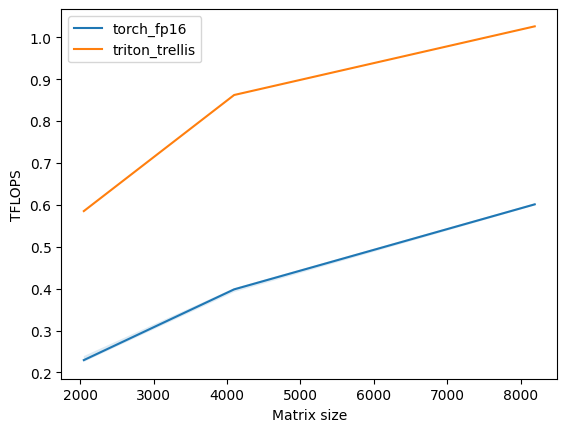

In [6]:
BS = 1
sizes = [2048, 4096, 8192]

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],  
        # x_vals=[(size, BS * size, size) for size in sizes],
        x_vals=[(size, BS, size) for size in sizes],
        line_arg="provider",  
        line_vals=[
            "torch_fp16", 
            "triton_trellis"
        ],
        line_names=[
            "torch_fp16", 
            "triton_trellis"
        ],  
        ylabel="TFLOPS",
        xlabel="Matrix size",
        plot_name="matmul-performance",
        args={},
    ))

@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda")
    x_fp16 = torch.randn(K, N, dtype=torch.float16, device="cuda")

    x_compressed = torch.randint(0, 255, (K // 16, N * 4), dtype=torch.uint8, device="cuda")
    
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        print(f"\n[M x K x N]: [{M} x {K} x {N}]")
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_fp16), quantiles=quantiles)

    if provider == 'triton_trellis':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: trellis_matmul_triton(y_fp16, x_compressed), quantiles=quantiles)
        print("trellis_matmul_triton:", matmul_trellis_kernel.best_config)

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=False, print_data=True)